Train set: 162770
Validation set: 19867
Test set: 19962


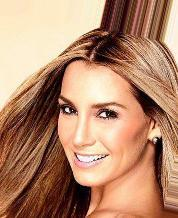

1


In [4]:
import torchvision 
from IPython.display import display

image_path = './'
celeba_train_dataset = torchvision.datasets.CelebA(image_path, split='train', target_type='attr', download=False)
celeba_valid_dataset = torchvision.datasets.CelebA(image_path, split='valid', target_type='attr', download=False)
celeba_test_dataset = torchvision.datasets.CelebA(image_path, split='test', target_type='attr', download=False)

print('Train set:', len(celeba_train_dataset))
print('Validation set:', len(celeba_valid_dataset))
print('Test set:', len(celeba_test_dataset))

row = celeba_train_dataset[0]
image = row[0]
smiling = row[1][31].item()
display(image)
print(smiling)

In [6]:
from datasets import Dataset, Features, ClassLabel, Array2D, Image
import torch
from torch.utils.data import Subset

# instead of using all the available training and validation data, we will take a subset of 16,000 training examples and 1,000 examples for validation, as our goal here is to intentionally train our model with a small dataset:
celeba_train_dataset = Subset(celeba_train_dataset, torch.arange(16000)) 
celeba_valid_dataset = Subset(celeba_valid_dataset, torch.arange(1000)) 

print('Train set:', len(celeba_train_dataset))
print('Validation set:', len(celeba_valid_dataset))

# Define a generator function
def train_data_generator():
    for item in celeba_train_dataset:
        image, attr = item
        
        label = attr[31].item() # smiling label
        
        yield {
            'image': image,  # Directly yield the PIL image
            'label': label,
        }

def valid_data_generator():
    for item in celeba_valid_dataset:
        image, attr = item
        
        label = attr[31].item() # smiling label
        
        yield {
            'image': image,  # Directly yield the PIL image
            'label': label,
        }

def test_data_generator():
    for item in celeba_test_dataset:
        image, attr = item
        
        label = attr[31].item() # smiling label
        
        yield {
            'image': image,  # Directly yield the PIL image
            'label': label,
        }

# Define the features of your dataset
features = Features({
    'image': Image(decode=True, id=None),  # The image is directly handled as an image
    'label': ClassLabel(num_classes=2),  
})

#TODO: will wanna handle test, valid.  give hf_dataset the name train.
# Create the Hugging Face dataset
train_dataset = Dataset.from_generator(generator=train_data_generator, features=features)
valid_dataset = Dataset.from_generator(generator=valid_data_generator, features=features)
test_dataset = Dataset.from_generator(generator=test_data_generator, features=features)

Train set: 16000
Validation set: 1000


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218 at 0x1430D4750>, 'label': 1}


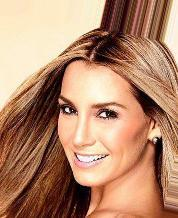

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218 at 0x1430CA7D0>, 'label': 1}


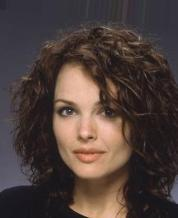

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218 at 0x1430B7350>, 'label': 1}


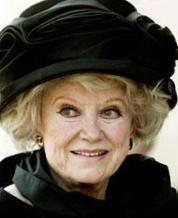

In [7]:
print(train_dataset[0])
display(train_dataset[0]['image'])
print(valid_dataset[0])
display(valid_dataset[0]['image'])
print(test_dataset[0])
display(test_dataset[0]['image'])


In [8]:
from transformers import AutoImageProcessor
checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

from torchvision import transforms 

transform_train = transforms.Compose([
    transforms.RandomCrop([178, 178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
])

transform = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
])

def train_transforms(examples):
    examples["pixel_values"] = [transform_train(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

def test_transforms(examples):
    examples["pixel_values"] = [transform(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples


train_dataset = train_dataset.with_transform(train_transforms)
train_dataset = train_dataset.shuffle(seed=1) # Shuffle the train_dataset
valid_dataset = valid_dataset.with_transform(test_transforms)
test_dataset = test_dataset.with_transform(test_transforms)

In [9]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

import evaluate

accuracy = evaluate.load("accuracy")

import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [10]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=2,
)

training_args = TrainingArguments(
    output_dir="smile_model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/750 [00:00<?, ?it/s]

{'loss': 0.6944, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.04}
{'loss': 0.6771, 'learning_rate': 1.3333333333333333e-05, 'epoch': 0.08}
{'loss': 0.6437, 'learning_rate': 2e-05, 'epoch': 0.12}
{'loss': 0.5663, 'learning_rate': 2.6666666666666667e-05, 'epoch': 0.16}
{'loss': 0.4064, 'learning_rate': 3.3333333333333335e-05, 'epoch': 0.2}
{'loss': 0.3025, 'learning_rate': 4e-05, 'epoch': 0.24}
{'loss': 0.2128, 'learning_rate': 4.666666666666667e-05, 'epoch': 0.28}
{'loss': 0.2614, 'learning_rate': 4.962962962962963e-05, 'epoch': 0.32}
{'loss': 0.2387, 'learning_rate': 4.888888888888889e-05, 'epoch': 0.36}
{'loss': 0.2465, 'learning_rate': 4.814814814814815e-05, 'epoch': 0.4}
{'loss': 0.2163, 'learning_rate': 4.740740740740741e-05, 'epoch': 0.44}
{'loss': 0.1958, 'learning_rate': 4.666666666666667e-05, 'epoch': 0.48}
{'loss': 0.1897, 'learning_rate': 4.592592592592593e-05, 'epoch': 0.52}
{'loss': 0.2, 'learning_rate': 4.518518518518519e-05, 'epoch': 0.56}
{'loss': 0.1705, 'learning

  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.20892255008220673, 'eval_accuracy': 0.91, 'eval_runtime': 835.7649, 'eval_samples_per_second': 1.197, 'eval_steps_per_second': 0.075, 'epoch': 1.0}
{'loss': 0.1589, 'learning_rate': 3.62962962962963e-05, 'epoch': 1.04}
{'loss': 0.1342, 'learning_rate': 3.555555555555556e-05, 'epoch': 1.08}
{'loss': 0.193, 'learning_rate': 3.481481481481482e-05, 'epoch': 1.12}
{'loss': 0.1749, 'learning_rate': 3.4074074074074077e-05, 'epoch': 1.16}
{'loss': 0.2081, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.2}
{'loss': 0.1419, 'learning_rate': 3.25925925925926e-05, 'epoch': 1.24}
{'loss': 0.1804, 'learning_rate': 3.185185185185185e-05, 'epoch': 1.28}
{'loss': 0.1511, 'learning_rate': 3.111111111111111e-05, 'epoch': 1.32}
{'loss': 0.1458, 'learning_rate': 3.037037037037037e-05, 'epoch': 1.36}
{'loss': 0.1545, 'learning_rate': 2.962962962962963e-05, 'epoch': 1.4}
{'loss': 0.1442, 'learning_rate': 2.8888888888888888e-05, 'epoch': 1.44}
{'loss': 0.1625, 'learning_rate': 2.8148148148

  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.19067567586898804, 'eval_accuracy': 0.924, 'eval_runtime': 739.9501, 'eval_samples_per_second': 1.351, 'eval_steps_per_second': 0.085, 'epoch': 2.0}
{'loss': 0.1457, 'learning_rate': 1.777777777777778e-05, 'epoch': 2.04}
{'loss': 0.1391, 'learning_rate': 1.7037037037037038e-05, 'epoch': 2.08}
{'loss': 0.1267, 'learning_rate': 1.62962962962963e-05, 'epoch': 2.12}
{'loss': 0.1309, 'learning_rate': 1.5555555555555555e-05, 'epoch': 2.16}
{'loss': 0.1095, 'learning_rate': 1.4814814814814815e-05, 'epoch': 2.2}
{'loss': 0.1162, 'learning_rate': 1.4074074074074075e-05, 'epoch': 2.24}
{'loss': 0.1312, 'learning_rate': 1.3333333333333333e-05, 'epoch': 2.28}
{'loss': 0.1759, 'learning_rate': 1.2592592592592592e-05, 'epoch': 2.32}
{'loss': 0.1321, 'learning_rate': 1.1851851851851853e-05, 'epoch': 2.36}
{'loss': 0.1437, 'learning_rate': 1.1111111111111112e-05, 'epoch': 2.4}
{'loss': 0.1194, 'learning_rate': 1.037037037037037e-05, 'epoch': 2.44}
{'loss': 0.1527, 'learning_rate': 9.62

  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.18458141386508942, 'eval_accuracy': 0.92, 'eval_runtime': 753.4328, 'eval_samples_per_second': 1.327, 'eval_steps_per_second': 0.084, 'epoch': 3.0}
{'train_runtime': 110257.1332, 'train_samples_per_second': 0.435, 'train_steps_per_second': 0.007, 'train_loss': 0.19640526405970254, 'epoch': 3.0}


TrainOutput(global_step=750, training_loss=0.19640526405970254, metrics={'train_runtime': 110257.1332, 'train_samples_per_second': 0.435, 'train_steps_per_second': 0.007, 'train_loss': 0.19640526405970254, 'epoch': 3.0})

In [ ]:
from transformers import pipeline
classifier = pipeline("image-classification", model="smile_model")
classifier(train_dataset[0]['image'])

In [ ]:
correct_predictions = 0
total_predictions = 0

for image, true_label in test_dataset:
    # Get prediction
    outputs = classifier(image)
    
    # The prediction is in the first element of outputs
    predicted_label = outputs[0]['label']
    
    # Compare with true label
    correct_predictions += int(predicted_label == true_label)
    total_predictions += 1

# Calculate accuracy
accuracy = correct_predictions / total_predictions

print(f'Accuracy of the model on the test images: {accuracy * 100:.2f}%')